In [ ]:
import numpy as np
import qiskit
# qiskit.__version__
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import RYGate
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

In [1]:
# Araujo I, Park D, Petruccione F, da Silva AJ. A divide-and-conquer algorithm for
# quantum state preparation. Sci Rep 2021;11:6329.
# START gen_angles
def gen_angles(x):
    N = int(len(x))
    Nd2 = int(N/2)
    new_x = np.zeros(Nd2)
    if N>1:
        for k in range (0,Nd2):
            new_x[k] = np.sqrt(x[2*k]**2 + x[2*k+1]**2)
        # Recursive call
        inner_angles = gen_angles(new_x)
        angles = np.zeros(Nd2)
        for k in range (0,Nd2):
                if new_x[k] != 0:
                    if x[2*k] > 0:
                        angles[k] = 2*np.asin(x[2*k+1]/new_x[k])
                    else:
                        angles[k] = 2*np.pi-2*np.asin(x[2*k+1]/new_x[k])
                else:
                    angles[k] = 0
        if N>2:
            angles = np.concatenate((inner_angles, angles))
        return angles
# END gen_angles
print("Defined gen_angles(x)")

Defined gen_angles(x)
Defined gen_circuit(angles)


In [ ]:
# START gen_circuit
def gen_circuit(angles):
    N = int(len(angles))+1
    n = np.log2(N)
    #for k in enumerate(angles):
    #    print("ok") see general paper above
    
    circuit = QuantumCircuit(n)
    # angles[0]
    circuit.ry(angles[0], 0) # Controlled RY gate

    if 1>0: # angles[1]
        circuit.x(0)
        circuit.cry(angles[1], 0, 1) # Anti-Controlled RY gate
        circuit.x(0)

    if 1>0: # angles[2]
        circuit.cry(angles[2], 0, 1)

    if 1>0: # angles[3-4-5-6]
        circuit.x(0)
        circuit.x(1)
        c2ry = RYGate(angles[3]).control(2)
        circuit.append(c2ry, [0, 1, 2])
        circuit.x(0)
        circuit.x(1)

        circuit.x(0)
        c2ry = RYGate(angles[4]).control(2)
        circuit.append(c2ry, [0, 1, 2])
        circuit.x(0)
            
        circuit.x(1)
        c2ry = RYGate(angles[5]).control(2)
        circuit.append(c2ry, [0, 1, 2])
        circuit.x(1)
            
        c2ry = RYGate(angles[6]).control(2)
        circuit.append(c2ry, [0, 1, 2])
        
    return circuit
# END gen_circuit
print("Defined gen_circuit(angles)")

[0.169194173824, 0.1875, 0.169194173824, 0.125, 0.080805826176, 0.0625, 0.080805826176, 0.125]


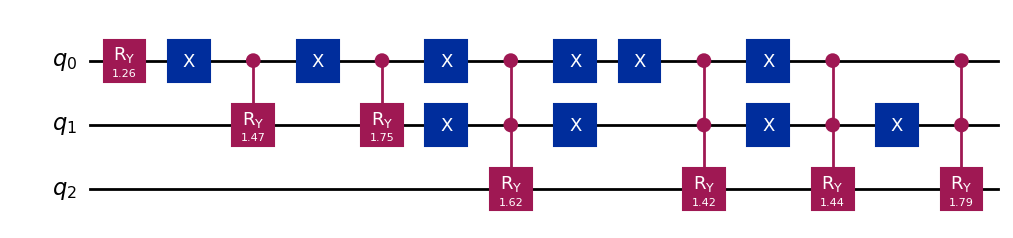

In [2]:
# p = [0.03,0.07,0.15,0.05,0.1,0.3,0.2,0.1] # probabilities

p = [0.169194173824, 0.187500000000, 0.169194173824, 0.125000000000,
     0.080805826176, 0.062500000000, 0.080805826176, 0.125000000000]

print(p)
x = np.sqrt(p) # amplitudes

# Compute the rotations
angles = gen_angles(x)
# print(angles)

# Create a quantum circuit
circuit = gen_circuit(angles)
circuit.draw("mpl")


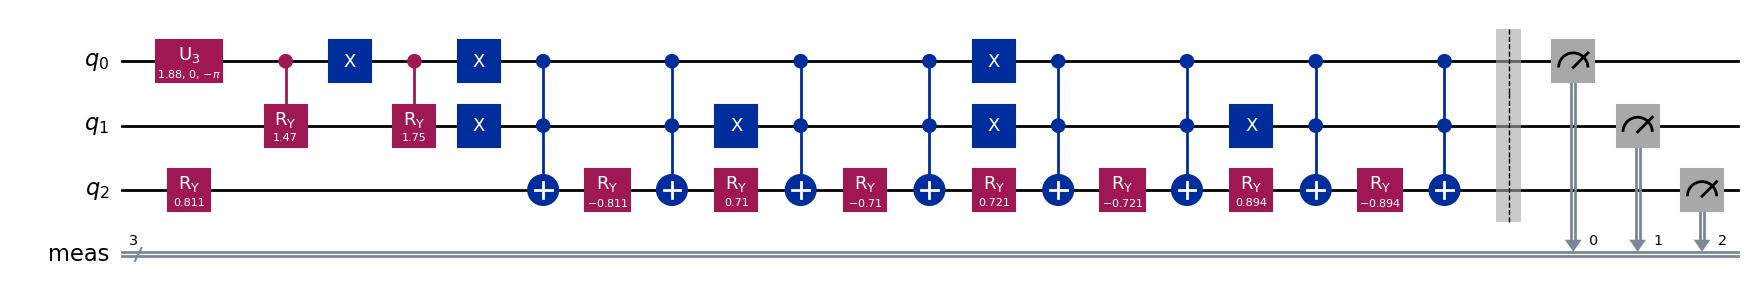

In [3]:
# Measure all qubits
circuit.measure_all()

# Transpile: converting the circuit to all 1 and 2 qubit gates
backend = BasicSimulator()
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
circuit_combine = pm.run(circuit)
circuit_combine.draw("mpl")

[0.169194173824, 0.1875, 0.169194173824, 0.125, 0.080805826176, 0.0625, 0.080805826176, 0.125]


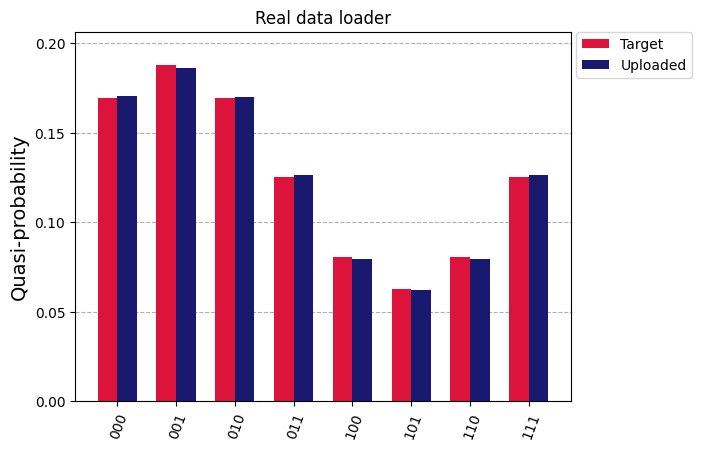

In [4]:
# Target to be loaded probabilities
print(p)

# Execute the circuit
N_shots = 100000
# Caution, ordering: The video linked above and many physics textbooks 
# use the Big Endian convention, where qubits in a multi-qubit system 
# are ordered from the least to most significant qubit as |q0 q1 … q(n-1)⟩. 
# Qiskit uses the Little Endian convention |q(n-1)… q1q0⟩ by default.
result = backend.run(circuit_combine.reverse_bits(), shots = N_shots).result()
counts = result.get_counts()

valth = N_shots * np.array(p)
countsth = {'000': int(valth[0]), '001': int(valth[1]), '010': int(valth[2]), 
            '011': int(valth[3]), '100': int(valth[4]), '101': int(valth[5]), 
            '110': int(valth[6]), '111': int(valth[7])} 
pth = {'000': p[0], '001': p[1], '010': p[2], 
            '011': p[3], '100': p[4], '101': p[5], 
            '110': p[6], '111': p[7]} 
legend = ['Target', 'Uploaded']

# Counts
#plot_histogram(counts)

# Counts
#plot_histogram([countsth, counts], legend=legend, color=['crimson','midnightblue'],
#                title="Real data loader")

# Quasi-probability
plot_histogram([pth, counts], legend=legend, color=['crimson','midnightblue'],
                title="Real data loader", bar_labels=False)
